## 0. Importing PyTorch and Setting up Device-Agnostic code

In [1]:
import torch
from torch import nn

torch.__version__

'2.1.0+cu121'

In [2]:
# Setup Device agnostic device
device  = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1.Get Data

Our dataset is a subset of Food101 dataset.

Food101 starts 101 different classes of food.

Our dataset starts wih 3 classes of food and only 10% of the images are used.

In [3]:
import requests
import zipfile
from pathlib import Path

# setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and preprare it ..

if image_path.is_dir():
  print(f"{image_path} directory already exists.. skipping download")
else:
  print(f"{image_path}  does not exist, creating one...")
  image_path.mkdir(parents=True,exist_ok=True)

# Download pizza, steak and shush data
with open (data_path/ "pizza_steak_sushi.zip","wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print(f"Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
  print("Unzipping data ...")
  zip_ref.extractall(image_path)


data/pizza_steak_sushi  does not exist, creating one...
Unzipping data ...


## 2. Data prepration and Data Exploration

In [4]:
import os

def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)}  images in {dirpath}")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0  images in data/pizza_steak_sushi
There are 3 directories and 0  images in data/pizza_steak_sushi/test
There are 0 directories and 25  images in data/pizza_steak_sushi/test/pizza
There are 0 directories and 31  images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 19  images in data/pizza_steak_sushi/test/steak
There are 3 directories and 0  images in data/pizza_steak_sushi/train
There are 0 directories and 78  images in data/pizza_steak_sushi/train/pizza
There are 0 directories and 72  images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 75  images in data/pizza_steak_sushi/train/steak


In [6]:
# Setup train and tesing path

train_dir = image_path/ "train"
test_dir = image_path/ "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2.1 Visualizing image

Random Image Path data/pizza_steak_sushi/train/sushi/3353428.jpg
Image class : sushi
Image Height : 512
Image Width : 512


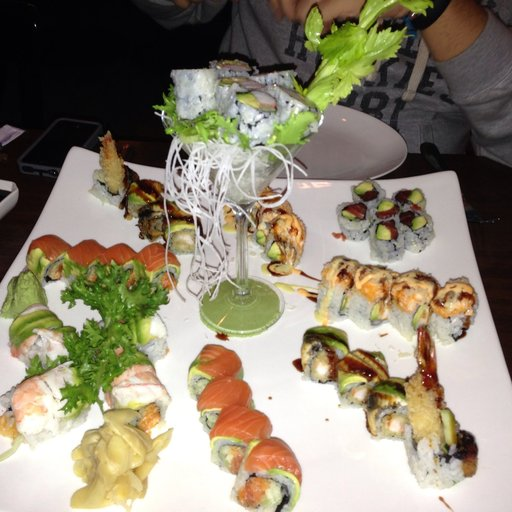

In [7]:
import random
from PIL import Image

# set seed
# random.seed(42)

# Get all the image paths
image_path_list  = list(image_path.glob("*/*/*.jpg"))

# Pick random image path
random_image_path = random.choice(image_path_list)
print(f"Random Image Path {random_image_path}")

# Get Image class from path name
image_class = random_image_path.parent.stem
print(f"Image class : {image_class}")

# Open image

img = Image.open(random_image_path)

# Print Meta data
print(f"Image Height : {img.height}")
print(f"Image Width : {img.width}")
img

(-0.5, 511.5, 511.5, -0.5)

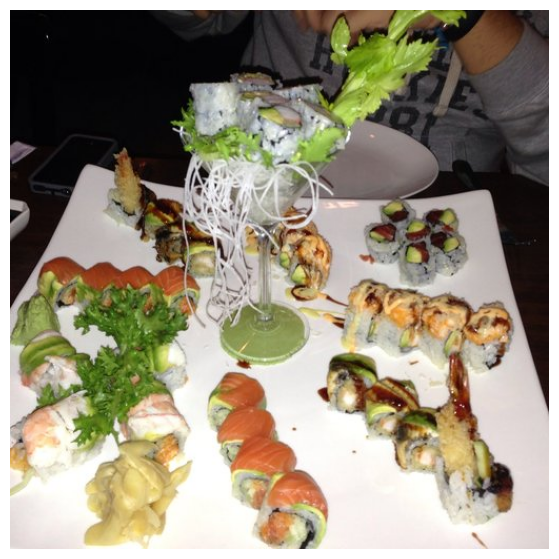

In [8]:
# Display Image using matplotlib :
import matplotlib.pyplot as  plt
import numpy as np

# Turm image to array
img_as_array = np.array(img)

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.axis(False)

## 3. Transforming data :

Before we can use our image dat with PyTorch:
- Turn target data into tensors
- Turn it into `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we will call
  these `Dataset` and `DataLoader`.
  

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [10]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize our image
    transforms.Resize(size=(64,64)),
    # Flip the image randomly on the horizontal
    transforms.RandomHorizontalFlip(p=1),
    # Turn Image into torch.Tensor
    transforms.ToTensor()
])

In [11]:
data_transform(img).shape

torch.Size([3, 64, 64])

In [12]:
data_transform(img).dtype

torch.float32

In [13]:
def plot_transformed_images(image_paths:list, transform,n=3,seed=42):
  """
  Select random images from a path of image and loads/transforms
  them then plots the original vs the transformed version.
  """

  if seed:
    random.seed(seed)
  random_image_path  = random.sample(image_paths, k=n)
  for image_path in random_image_path:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0) # C,H,W -> H,W,C
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\Shape:{transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class:  {image_path.parent.stem}", fontsize=16)

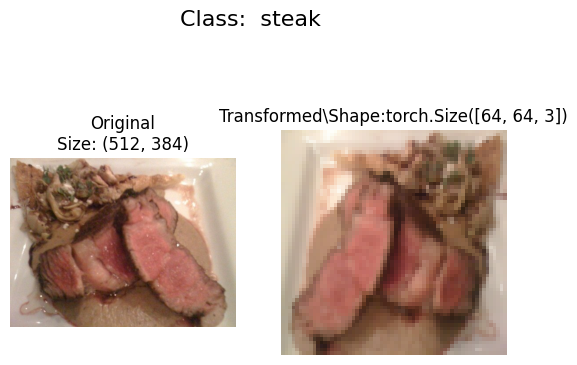

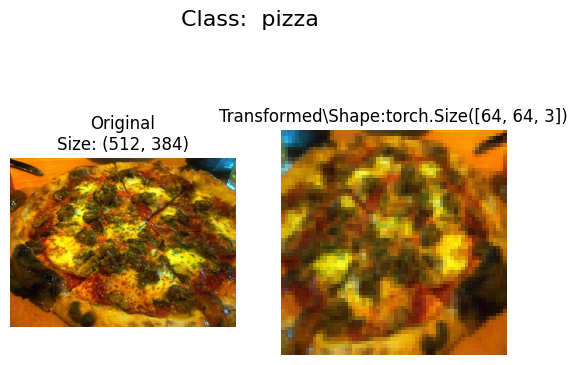

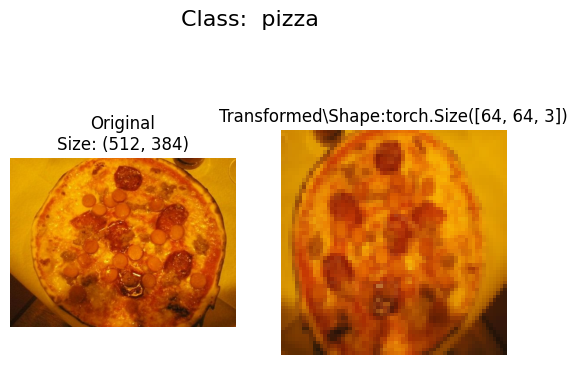

In [14]:
plot_transformed_images(image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

## 4. Option 1: Loading Image data using `ImageFolder`


In [15]:
# Use image folder
from torchvision import datasets
train_data = datasets.ImageFolder(root =train_dir,
                                  transform =data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root =test_dir,
                                  transform =data_transform,
                                  target_transform=None)
train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=1)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=1)
                ToTensor()
            ))

In [16]:
# get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [17]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [18]:
# Check the length of dataset
len(train_data), len(test_data)

(225, 75)

In [19]:
# Index on the train_data Dtaset to get a single image and lable
img,label= train_data[0][0], train_data[0][1]
img

tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0157, 0.0157, 0.

In [20]:
label

0

In [21]:
class_names[label]

'pizza'

In [22]:
print(f"Image tensor : \n{img}")
print(f"Image Shape : {img.shape}")
print(f"Image dataType : {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype {type(label)}")

Image tensor : 
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.

Text(0.5, 1.0, 'pizza')

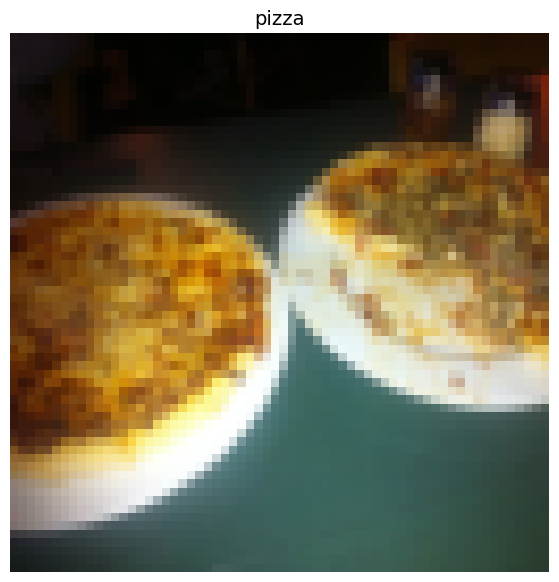

In [23]:
img_permute  = img.permute(1,2,0)

# plot the image
plt.figure(figsize=(10,7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

## 4.1 Turn loaded images into  `DataLoader's`

A `DataLoader` is going to help us turn our `Dataset`  into iterables and we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [24]:
# Turn train and test datasets into DataLoader
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              num_workers= os.cpu_count(),
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=32,
                              num_workers= os.cpu_count(),
                              shuffle=False)
train_dataloader , test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x790d559530a0>,
 <torch.utils.data.dataloader.DataLoader at 0x790c94682380>)

In [25]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [26]:
img, label = next(iter(train_dataloader))

print(f"Image shape:{img.shape}")
print(f"Label shape: {label.shape}")

Image shape:torch.Size([32, 3, 64, 64])
Label shape: torch.Size([32])


## 5 Option 2 : Loading Image Data with a Custome `Daset`

In [27]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple,Dict,List

In [28]:
train_data.classes , train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Create a helper function to get class names

In [29]:
target_directory = train_dir
print(f"Target dir : {target_directory}")

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir : data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [30]:
def find_classes(directory:str) -> Tuple[List[str], Dict[str,int]]:
  """Finds the class folder names in a target directory."""
  classes = sorted(entry.name for entry in list(os.scandir(directory)) if entry.is_dir())
  if not classes :
    raise FileNotFoundError(f"Couldn't find any classes in {directory}...")
  class_to_idx = {class_name : i for i, class_name in enumerate(classes)}
  return classes,class_to_idx

In [31]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## 5.2 Create custom dataset tp replicate  `ImageFolder`

In [32]:
# Wrie a custom dataset class

from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  # Initialize our custome dataset
  def __init__(self, target_dir:str, transforms=None):
    #Create class attribute
    self.path = list(pathlib.Path(target_dir).glob("*/*.jpg"))
    # Setup transform
    self.transform = transforms
    # Create classes anc class_to_idx attribute
    self.classes, self.class_to_idx =  find_classes(target_dir)

  # Create a function to load images
  def  load_image(self,index:int) -> Image.Image:
    image_path = self.path[index]
    return Image.open(image_path)

  # Overrite __len__()
  def __len__(self) -> int:
    return len(self.path)

  # Overrite __getitem__() method to return a particular sample
  def __getitem__(self,index:int) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.path[index].parent.name
    class_to_idx = self.class_to_idx[class_name]

    # Transorm
    if self.transform:
      return self.transform(img), class_to_idx
    else :
      return img, class_to_idx

In [33]:
# Create a transform
train_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [34]:
# Test out ImageFolderCustom

train_data_custom = ImageFolderCustom(target_dir=train_dir,
                                      transforms = train_transforms)
test_data_custom = ImageFolderCustom(target_dir=test_dir,
                                      transforms = train_transforms)

In [35]:
train_data_custom, train_data_custom

(<__main__.ImageFolderCustom at 0x790c788d6980>,
 <__main__.ImageFolderCustom at 0x790c788d6980>)

In [36]:
len(train_data_custom) , len(train_data)

(225, 225)

In [37]:
len(test_data_custom) , len(test_data)

(75, 75)

In [38]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [39]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

### 5.3 Create  a function to display random images

In [40]:
def display_random_images(dataset : torch.utils.data.Dataset,
                          classes : List[str] = None,
                          n:int = 10,
                          display_shape:bool = True,
                          seed : int = None):
  # Adjust Display
  if n > 10:
    n=10
    display_shape = False
    print(f"For display, purposes, n shouldn't be larger than 10, setting to 10 and reoving shape display.")

  # Set the seed
  if seed:
    random.seed(seed)

  # Get Random Sample indexex
  random_samples_idx = random.sample(range(len(dataset)), k=n)

  # Setup plot
  plt.figure(figsize=(16,8))

  # Loop throught the random indexed and plot them with matplotlib
  for i , targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    targ_image_adjust = targ_image.permute(1,2,0)
    plt.subplot(1,n,i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class : {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape : {targ_image_adjust.shape}"
    plt.title(title)


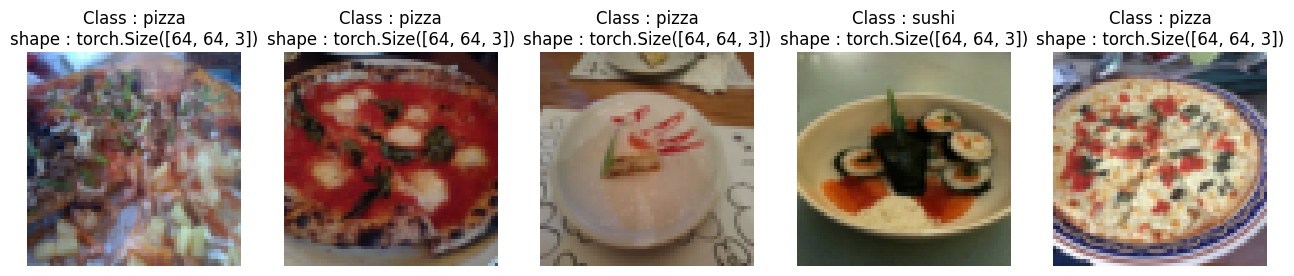

In [41]:
display_random_images(train_data,
                      n=5,
                      classes=class_names, seed=None)

For display, purposes, n shouldn't be larger than 10, setting to 10 and reoving shape display.


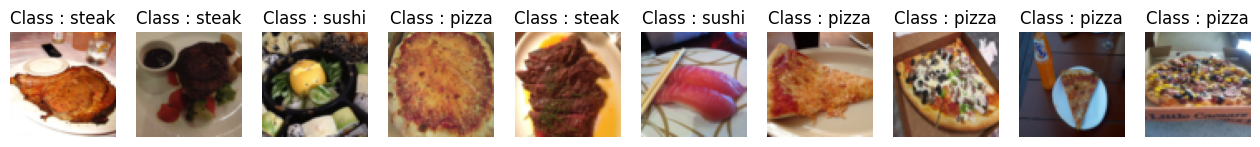

In [42]:
display_random_images(dataset=train_data_custom,
                      n=12,
                      classes=class_names, seed=None)

In [43]:
# Turn train and test datasets into DataLoader
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                              batch_size=BATCH_SIZE,
                              num_workers= os.cpu_count(),
                              shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                              batch_size=BATCH_SIZE,
                              num_workers= os.cpu_count(),
                              shuffle=False)
train_dataloader_custom , test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x790c78aa6c80>,
 <torch.utils.data.dataloader.DataLoader at 0x790c78aa4280>)

In [44]:
# Get Image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))
img_custom.shape,label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of Trasformation  (Data Augmentation)

In [45]:
# Let's look at trivial augment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])


test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

In [46]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/pizza/2218680.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/344397.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/714866.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/540882.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2508636.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/648055.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1925494.jpg')]

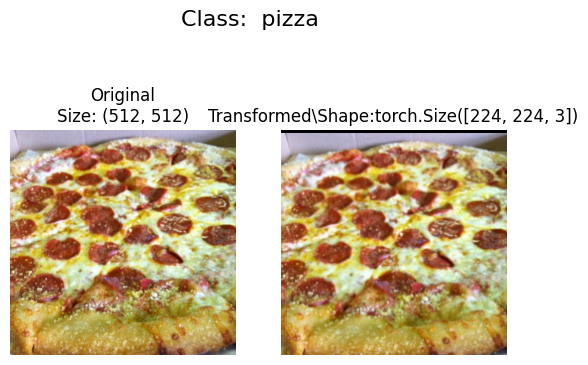

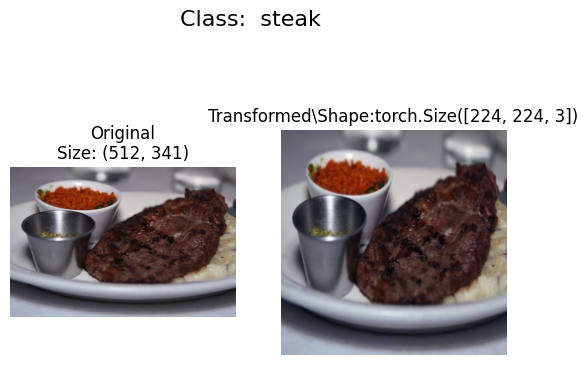

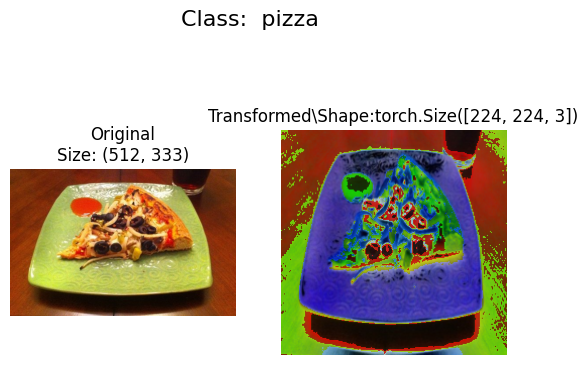

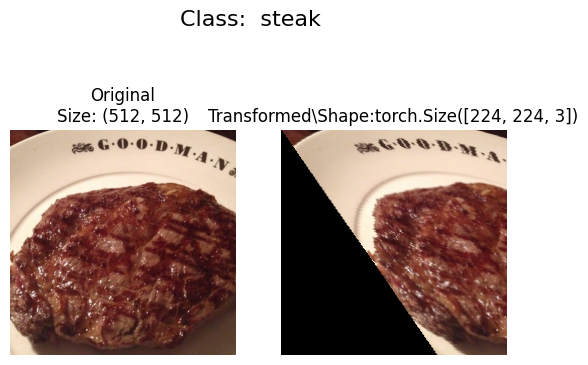

In [47]:
plot_transformed_images(
    image_paths = image_path_list,
    transform= train_transform,
    n=4,
    seed=None
)

## 7. Model 0 : TinyVGG without data augmentation

### 7.1 Creating transforms and loading data for Model 0

In [48]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [50]:
#  Load and Transform dats
from torchvision import datasets

train_data_simple = datasets.ImageFolder(root = train_dir,
                                         transform=simple_transform)
test_data_simple  = datasets.ImageFolder(root = test_dir,
                                         transform=simple_transform)

# Turn the dataset into data loader
import os
from torch.utils.data import DataLoader

# Setup batch size and number of works
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create Dataloader
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=NUM_WORKERS)

In [78]:
### 7.2  Create TinyVGG modal class
class TinyVGG(nn.Module):
  """
  Model Architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self,input_shape:int,
               hidden_units:int,
               output_shape:int) -> None:
               super().__init__()
               self.conv_block_1 = nn.Sequential(
                   nn.Conv2d(in_channels=input_shape,
                             out_channels=hidden_units,
                             kernel_size =3,
                             stride=1,
                             padding=0),
                   nn.ReLU(),
                   nn.Conv2d(in_channels=hidden_units,
                             out_channels=hidden_units,
                             kernel_size=3,
                             stride=1,
                             padding=0),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=2,
                                stride=2)
               )
               self.conv_block_2 = nn.Sequential(
                   nn.Conv2d(in_channels=hidden_units,
                             out_channels=hidden_units,
                             kernel_size =3,
                             stride=1,
                             padding=0),
                   nn.ReLU(),
                   nn.Conv2d(in_channels=hidden_units,
                             out_channels=hidden_units,
                             kernel_size=3,
                             stride=1,
                             padding=0),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=2,
                                stride=2)
               )

               self.classifier = nn.Sequential(
                   nn.Flatten(),
                   nn.Linear(in_features=hidden_units*13*13,
                             out_features =output_shape,
                             )
               )

  def forward(self,x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x =self.conv_block_2(x)
    # print(x.shape)
    x =self.classifier(x)
    # print(x.shape)
    return x


In [79]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape = len(class_names)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a single image

In [80]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [81]:
model_0(image_batch)

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 `torchinfo` to get an idea of shape of our model going through  our Model

In [82]:
# Install torchinfo, import if it's available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## 7.5 Create train and test loops functions

* `train_step()` - Takes in a model and dataloader and trains the model on the dataloader.
* `test_step()` - Takes in a model and dataloader and evaluates the model on the dataloader.

In [83]:
# Create train_step()

def train_Step(model: torch.nn.Module,
               dataloader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  tran_loss, train_acc = 0,0

  # Loop through data loader batches
  for batch, (X,y) in enumerate(dataloader):
    # send data to the target device
    X,y = X.to(device) , y.to(device)

    # 1. Forward Pass
    y_pred = model(X)

    # 2. Calculate the loss
    loss = loss_fn(y_pred,y)
    train_loss += loss.item()

    # 3. Optimize the zero grad
    optimizer.zero_grad()

    #4. Loss backward
    loss.backward()

    #5. Optimize step
    optimizer.step()

    # Calculate accuracy matrix
    y_pred_class = torch.argmax(torch.softma(y_pred,dim=1), dim=1)
    train_ac += (y_pred_class ==y).sum().item()/len(y_pred)

  # Adjust matrix to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss,train_acc


In [84]:
# Create  a test step

def test_step(model:torch.nn.Module,
              dataloader : torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy value
  lest_loss, test_Acc = 0,0

  # Trun on inference mode
  with torch.inference_model():
    # Loop through DataLoader batches
    for batch, (X,y) in enumerate(dataloader):
      # send data to the target device
      X,y = X.to(device),y.to(device)

      # 1. Forward Pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits,y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      tet_acc += ((test_pred_labels ==y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss ,test_acc